In [1]:
import numpy as np
import tensorflow as tf
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
os.chdir('../')
from function import make_data

In [3]:
df = make_data(dt = 1, total_time = 10000)

In [4]:
geom = dde.geometry.TimeDomain(0, 10000)
ic = dde.IC(geom, lambda X: data_df['u'].iloc[0], lambda _, on_initial: on_initial)

In [5]:
t = df['time'].values[:, None]
u = df['u'].values
f = df['f'].values

def func(t):
    u = np.interp(t, data_df['time'], data_df['u'])
    f = np.interp(t, data_df['time'], data_df['f'])
    return u, f

In [6]:
alpha, beta, gamma = [-45.93857163, 117.18149753,  63.07236099]

In [7]:
def bouc_wen(_, u):
    z = u
    du_dt = -alpha * z - beta * z * tf.abs(z) - gamma * z**2
    return [du_dt]


In [8]:
data = dde.data.PDE(
    geom,
    bouc_wen,
    bcs=[],
    num_domain=5000,
    num_boundary=2,
    solution=None,
    num_test=1000,
    train_distribution="uniform",
)


In [9]:
net = dde.maps.FNN([1] + [200] * 2 + [1], "sin", "Glorot normal")

In [10]:
model = dde.Model(data, net)
model.compile("L-BFGS", lr=0.001)
losshistory, train_state = model.train(epochs=15000)

Compiling model...
Building feed-forward neural network...
'build' took 0.026726 s

'compile' took 0.096978 s



Training model...

Step      Train loss    Test loss     Test metric
0         [9.33e+03]    [9.39e+03]    []  


c:\Users\user\Anaconda3\envs\gpu\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


1000      [1.88e+01]    [1.88e+01]        
2000      [1.50e+01]    [1.50e+01]        
3000      [1.29e+01]    [1.29e+01]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 12.789599
  Number of iterations: 3186
  Number of functions evaluations: 3321
3321      [1.28e+01]    [1.28e+01]    []  

Best model at step 3321:
  train loss: 1.28e+01
  test loss: 1.28e+01
  test metric: []

'train' took 82.962958 s



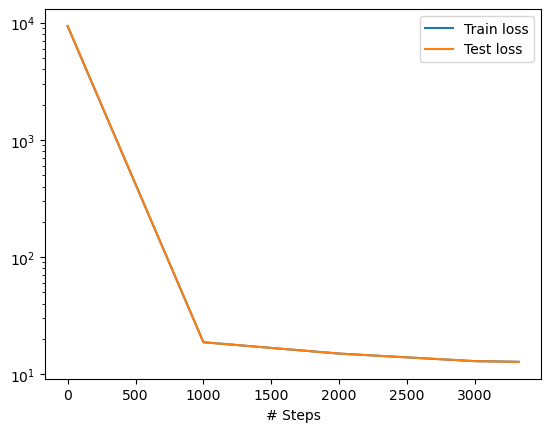

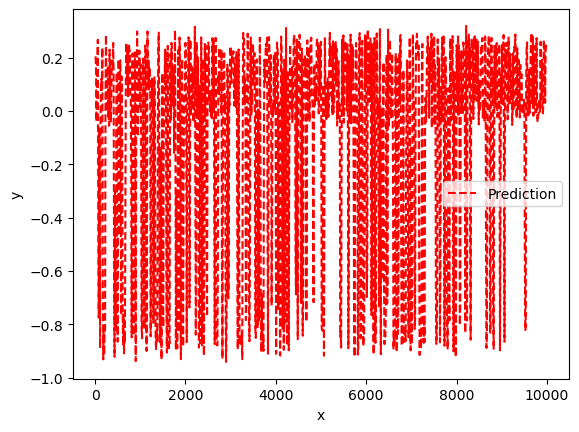

In [11]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [12]:
import matplotlib.pyplot as plt

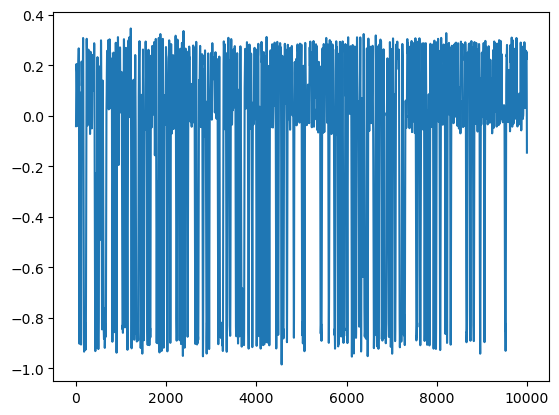

In [13]:
plt.plot(model.predict(t))